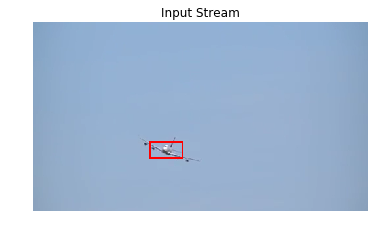

In [5]:
# Mean Shift Example

import numpy as np
import cv2
from IPython.display import clear_output

%pylab inline 

vid = cv2.VideoCapture('resources/images/planeCam.mp4')
# take first frame of the video

ret,frame = vid.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

# setup initial location of window
r,c,h,w = 140,220,25,50  # simply hardcoded the values
track_window = (c,r,w,h)

plt.figure("Mean Shift Example")
plt.imshow(frame)
plt.show()

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]

# converting the ROI from BGR to HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
        
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # Draw it on image
        x,y,w,h = track_window
        
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        # Turn off the axis
        axis('off')
        
        # Title of the window
        title("Input Stream")
        
        # Display the frame
        imshow(img2)
        show()
        
        # Display the frame until new frame is available
        clear_output(wait=True)
        
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()

In [11]:
# Cam Shift Example

import numpy as np
import cv2
from IPython.display import clear_output

%pylab inline 

vid = cv2.VideoCapture('resources/images/planeCam.mp4')
# take first frame of the video

ret,frame = vid.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

# setup initial location of window
r,c,h,w = 140,220,25,50  # simply hardcoded the values
track_window = (c,r,w,h)

plt.figure("Cam Shift Example")
plt.imshow(frame)
plt.show()

# set up the ROI for tracking


roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
        
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # apply camshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        
        # Draw it on image
        x,y,w,h = track_window
        
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        # Turn off the axis
        axis('off')
        
        # Title of the window
        title("Input Stream")
        
        # Display the frame
        imshow(img2)
        show()
        
        # Display the frame until new frame is available
        clear_output(wait=True)
        
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()

In [14]:
# Video Stabilization

import numpy as np
import cv2
from IPython.display import clear_output

%pylab inline 

class Stabilizer:
    def stabilize(self, new_frame, old_frame):


            # params for ShiTomasi corner detection
            feature_params = dict( maxCorners = 100,qualityLevel = 0.3,minDistance = 7,blockSize = 7 )

            # Parameters for lucas kanade optical flow
            lk_params = dict( winSize  = (15,15),
                              maxLevel = 2,
                              criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

            # Create some random colors
            color = np.random.randint(0,255,(100,3))

            old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            
            # Use goodFeaturesToTrack to get the corners in the old_frame
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            
            new_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

            # calculate optical flow using LK between the old and new frame, and get the corresponding corners
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)
            
            # Select good points
            good_new = p1[st==1]
            good_old = p0[st==1]


            # Use homography, to get the perspective transform matrix.
            h = cv2.findHomography(good_old, good_new)
            
            result=cv2.warpPerspective(new_frame, h[0], (new_frame.shape[1],new_frame.shape[0]))

            return new_frame, result
        
        


Populating the interactive namespace from numpy and matplotlib


In [15]:
import cv2
import sys
from imutils.video import VideoStream
import time


imageCapture = cv2.VideoCapture('resources/images/planeCam.mp4')
_,frame = imageCapture.read()

stabilizer=Stabilizer()

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure("Video Stabilization")
plt.imshow(frame)
plt.show()

while True:
    time.sleep(0.5)
    _,image=imageCapture.read()
    
    # call stabilize function of the Stabilizer class 
    frame, result=stabilizer.stabilize(image, frame)
    
    # Display the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    imshow(frame)
    show()
        
    # Display the frame until new frame is available
    clear_output(wait=True)


KeyboardInterrupt: 